In [1]:
# %%
# Modern TCN 推荐参数
import numpy as np
from tqdm import tqdm
from typing import List
import torch
from torch import nn, Tensor
import torch.utils.data as Data

# %matplotlib widget
from typing import List
import datetime
now = datetime.datetime.now().strftime('%b%d_%H-%M')

from mix_data_pos_all import *

import matplotlib.pyplot as plt
from matplotlib import font_manager
source_han_sans_path = '/home/huxianan/.local/share/fonts/adobe-source-han-sans/SourceHanSansCN-Normal.otf'
my_font = font_manager.FontProperties(fname=source_han_sans_path)
font_manager.fontManager.addfont(source_han_sans_path)
plt.rcParams['font.family'] = my_font.get_name()
plt.rcParams['axes.unicode_minus'] = False


In [2]:
use_cuda = True
device = torch.device(f"cuda:0" if (
    use_cuda and torch.cuda.is_available()) else "cpu")
# device = torch.device("cpu")
print("CUDA Available: ", torch.cuda.is_available(), 'use:', device)



CUDA Available:  True use: cuda:0


In [3]:

TAG_LEN = 12
BATCH_SIZE = 256
# INPUT_CHANNELS = 5 
# POS_D = D = 128
# P = 1
# S = 1
# R = 2
# NUM_LAYERS = 24
# DROP_OUT = 0.5 # dropout 仅指分类头的。不能在主干。ref. https://arxiv.org/abs/1801.05134v1
# HARD_RATIO = 80

# TCN: modern TCN
# Linear 线性（模）值域宽尺度特征提取
# mask（mean 掩码）掩码难样本处理 randMask 随机掩码
# D L R: TCN 参数
# MT: 混入测试集 mix test
# Easy: 2,2,1,2
# H: hard
    
IF_LAERNABLE_EMB = False
IF_LAERNABLE_EMB = True
if IF_LAERNABLE_EMB:
    from my_datastes import MyDataSet_woEmb as MyDataSet
else:
    from my_datastes import MyDataSet

from my_tools import *
seed_everything()

# 训练数据准备
def make_data(d: List[List[np.ndarray]]):
    """生成数据集
    Args:
        d 数据集
    Returns:
        inputs2 = 特征
        targets = [[TAG] * 时间窗长度] * 样本数 one-hot 编码
    """
    inputs = np.array([i[0] for i in d], dtype=np.float32)
    targets = np.array([i[-1] for i in d], dtype=np.int64) - 1

    # 对 'TAG' 列的值 1~12 进行 one-hot 编码
    # targets = np.eye(12)[targets - 1] #(原标签 -1) 作为索引，生成对应的单位矩阵
    
    return torch.FloatTensor(inputs), torch.LongTensor(targets)


df_list, test_df_list = read_dfs()

# %%
# 释放显卡内存
torch.cuda.empty_cache()

# %%
def criterion(outputs: torch.FloatTensor, targets: torch.FloatTensor):
    """自定义 loss function
    loss_1 : 模型最终输出的交叉熵损失
    """
    
    # loss_1 = focal_loss(outputs.view(-1, 12), targets.view(-1), alpha=None, reduction='mean')
    loss_1 = nn.CrossEntropyLoss()(outputs.view(-1, 12), targets.view(-1))
    return loss_1



set all seed: 3407
并行读取数据集中... 读取数据集 end


In [4]:
# NAME = './saved_models/TCN_51KS5_128D24L2R5dp_PosAll80Hrc1R_MT_May09_08-48_mloss.pth'
# NAME = './saved_models/TCN_51KS5_128D24L2R5dp_PosAll80Hrr1R_MT_May08_12-51_mloss.pth'
# NAME = './my_models/TCN_51KS5_128D24L2R0dp_2lr_PosAll75Hr1R_MT_mloss_0.129_cp-822.pth'
# NAME = './my_models/TCN_51KS5_128D24L2R5dp_PosAll80Hr1R_MT_mloss_0.180_cp-311.pth'
# NAME = './my_models/TCN_51KS5_128D24L2R5dp_2lr_PosAll0Hr1R_MT_cp-399.pth'
# NAME = './saved_models/TCN_51KS5_128D24L2R5dp_PosAll80Hr1R_MT_LEmb_May06_14-01_mloss.pth'


# NAME = './saved_models/TCN_51KS5_128D24L2R5dp_PosAll80Hrr1R_MT_May08_12-51_mloss.pth' # 宽值域嵌入+随机掩码
# NAME = './saved_models/TCN_51KS5_128D24L2R5dp_PosAll80Hrc1R_MT_May09_08-48_mloss.pth' # 宽值域嵌入+常数掩码
# NAME = './saved_models/TCN_51KS5_128D24L2R5dp_PosAll80Hr1R_MT_May07_08-56_mloss.pth' # 宽值域嵌入+均值掩码
# NAME = './saved_models/TCN_51KS5_128D24L2R5dp_PosAll0Hr1R_MT_May07_12-08_mloss.pth' # 宽值域嵌入+无掩码
NAME = './saved_models/TCN_51KS5_128D24L2R5dp_PosAll80Hr1R_MT_LEmb_May06_14-01_mloss.pth' # 自学习嵌入+无掩码

checkpoint = torch.load(f'{NAME}', map_location=torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu'))



335


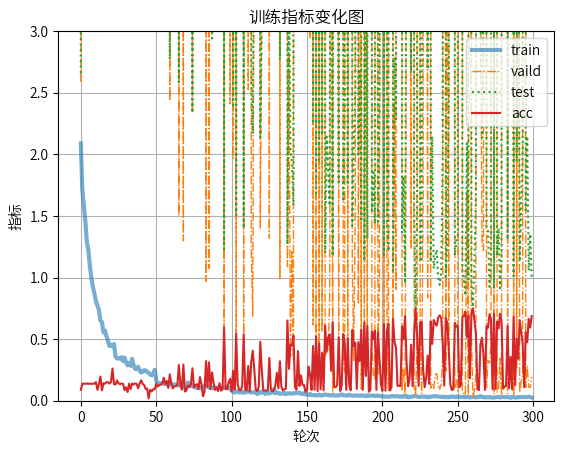

In [5]:
loss_record = checkpoint['loss_record']
print(len(loss_record["train"]))
# max_epoch = 300
# for k, v in loss_record.items():
#     if len(v) > max_epoch:
#         loss_record[k] = v[:max_epoch]

plt.figure()
plt.plot(loss_record["train"], label="train", linestyle="-", linewidth=3, alpha=0.6)
plt.plot(loss_record["vaild"], label="vaild", linestyle="-.", linewidth=1)
plt.plot(loss_record["test"], label="test", linestyle=":")
plt.plot(loss_record["acc"], label="acc", linestyle="-")
plt.grid()
plt.ylim(0, 3)
plt.legend()
plt.xlabel('轮次')
plt.ylabel('指标')
plt.title(f'训练指标变化图')
plt.savefig(f'tmp.svg')
plt.show()
plt.close()

In [6]:
model = checkpoint['model']
model.structural_reparam()
# # ! 需要 2.0+ torch
# model = torch.compile(model)
# torch.set_float32_matmul_precision('high')

print("参数量：", sum(p.numel() for p in model.parameters() if p.requires_grad), end=' ')

model.to(device)
model.eval()


参数量： 9076748 

ModernTCNnew(
  (stem): Sequential(
    (0): Conv1d(1, 128, kernel_size=(1,), stride=(1,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (stages): Stage(
    (blocks): ModuleList(
      (0-23): 24 x Block(
        (dw): ReparamLargeKernelConv(
          (lkb_reparam): Conv1d(640, 640, kernel_size=(51,), stride=(1,), padding=(25,), groups=640)
        )
        (norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (ffn1pw1): Conv1d(640, 1280, kernel_size=(1,), stride=(1,), groups=5)
        (ffn1act): GELU(approximate='none')
        (ffn1pw2): Conv1d(1280, 640, kernel_size=(1,), stride=(1,), groups=5)
        (ffn1drop1): Dropout(p=0.0, inplace=False)
        (ffn1drop2): Dropout(p=0.0, inplace=False)
        (ffn2pw1): Conv1d(640, 1280, kernel_size=(1,), stride=(1,), groups=128)
        (ffn2act): GELU(approximate='none')
        (ffn2pw2): Conv1d(1280, 640, kernel_size=(1,), stride=(1,), grou

100%|██████████| 4/4 [00:08<00:00,  2.10s/it]


Acc: 75.722, Pre: 76.863, Rec: 75.722, F1: 75.480 [weighted]


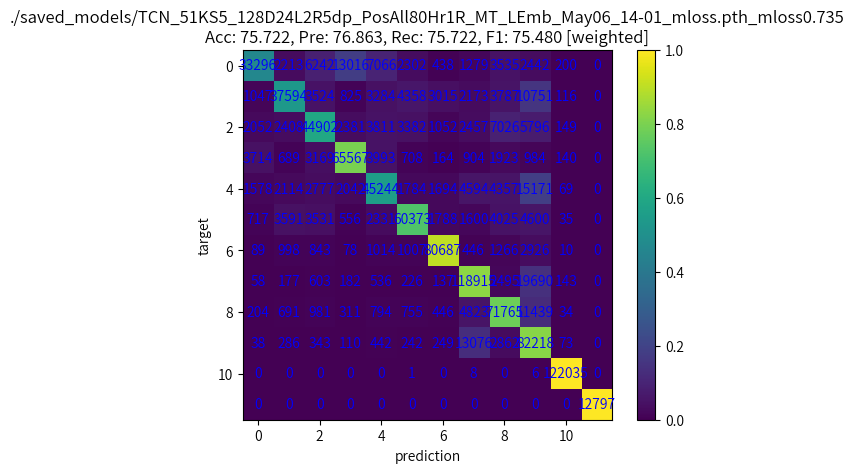

Average loss: 0.7353237122297287


In [7]:

with torch.no_grad():
    l = Data.DataLoader(MyDataSet(*make_data(target_domain_data_gen(test_df_list[2], 10, 100))), batch_size=BATCH_SIZE, shuffle=True)
    loss = 0
    predictions = np.array([]).astype(int)
    targets = np.array([]).astype(int)
    for data, target in tqdm(l):
        data = data.to(device)
        target = target.to(device)
        output = model(data)

        # 计算预测值
        predictions = np.append(predictions, torch.argmax(
            output.view(-1, 12), -1).cpu().numpy())

        targets = np.append(targets, target.view(-1).cpu().numpy())

        loss += criterion(output, target).item()

    loss /= len(l)


confusion_matrix(predictions, targets, f'{NAME}_mloss{loss:.3}', if_save=False)
# confusion_matrix(predictions, targets, f'{NAME}_mloss{loss:.3}', average='micro')
print(f'Average loss: {loss}')





### 宽值域嵌入+随机掩码

Acc: 94.207, Pre: 94.154, Rec: 94.207, F1: 94.164 [weighted]

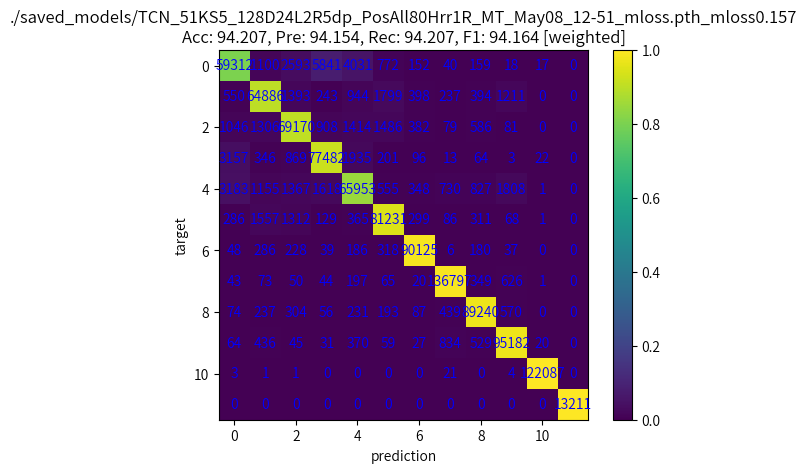

### 宽值域嵌入+常数掩码
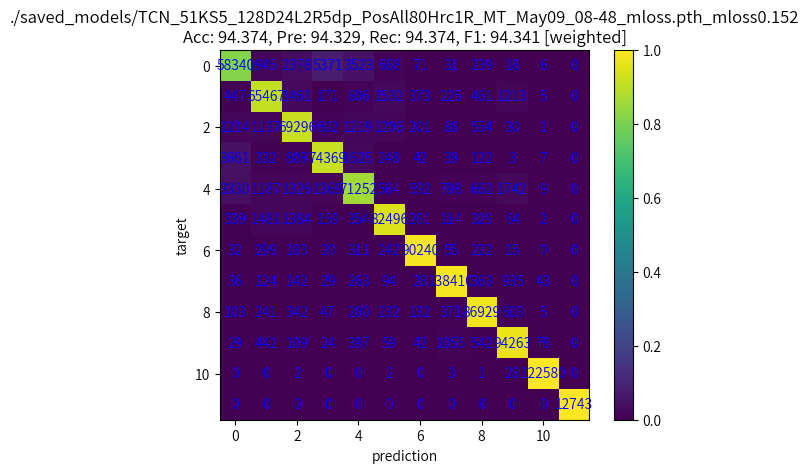

### 宽值域嵌入+均值掩码

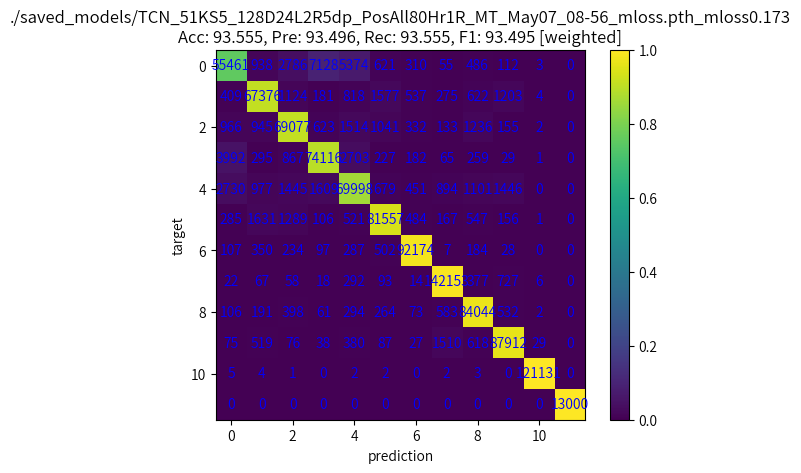

### 宽值域嵌入+无掩码

Acc: 84.252, Pre: 84.263, Rec: 84.252, F1: 84.020 [weighted]

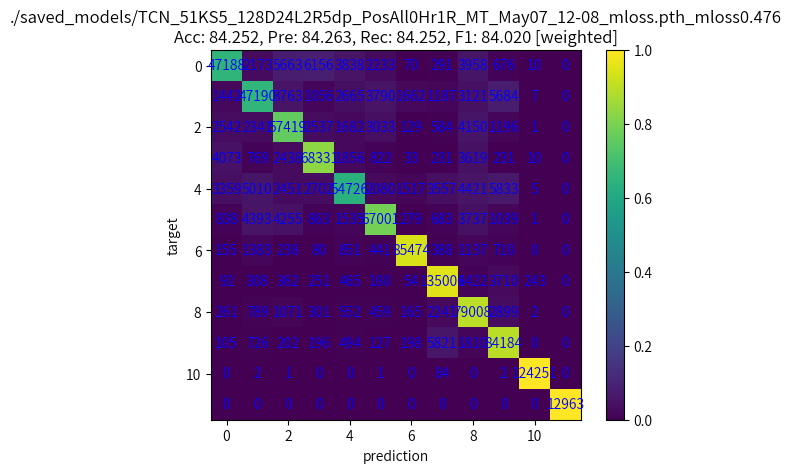

### 自学习嵌入+无掩码

Acc: 75.722, Pre: 76.863, Rec: 75.722, F1: 75.480 [weighted]

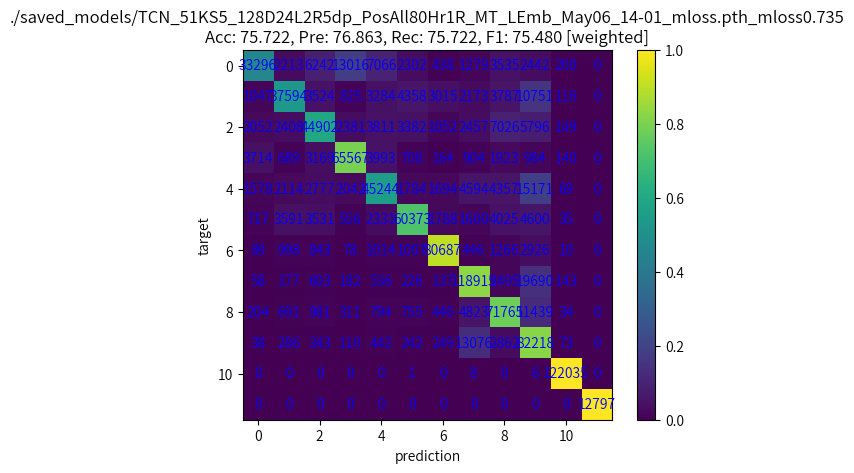